<a href="https://colab.research.google.com/github/GurpreetUppal/Multifaceted-Obesity-Prediction/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tire-sales-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4678168%2F7954259%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T054416Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3de43407507d4ea34fc7e0f50faf9170b482315b14ab457bd45167dfcf064a8d342a0f6a169fe926c476a7569fb04a8a787707d7fd8d14cbca6224a06a80e1848821f541b7df17fa0aee40c1510a06e905b1d3cd791897516c0404b352e8a0874b09ba21850d7c8b79dccb042347a97274492faf2efff51d29b48353f275d37949f85358a8e6e8bd6ceb640042c96c10f1c478d5c4ee9b889d366414a7d9adab8be10e91ee2302a56e132499f348f369c9f8459260f313c7760ba0559c1f49851ae6e0262bcc95bafeadd6c468f3da815bda8153309b4cab87ed9665b8c2c1c1160d7499789f5b5e2474d0b41e85a0a6419a3774753a8b3503728487f2740390'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

In [ ]:
tires_df = pd.read_csv('/kaggle/input/tire-sales-data/Tires Data kaggle.csv')
tires_df.head(5)

,Age Group,Neighbourhood,Education,Household income,Discount Code,Discount code obtained,High Qual Rim Last 5 Yrs,Household Size,Last Date of all seasons purchase,Last Date of summer purchase,Last Date of winter purchase,Primary Vehicle,Responded August Promo (all-season tires),Responded March promo (all seasons),Responded March Promo (summer tires),Responded November promo (winter tires),Responded October Promo (winter tires),Warranty Purchased,All Seasons Tires Sales,Instore Sales,Num Adult Drivers,Num Adults,Num Child 18 and Under,Num Young Drivers,Number of vehicles in household,Online Sales,Rough/Approx km per year,Services at Other Retailers,Summer Tires Sales,Total Drivers,Wheel/rim purchase,Winter Tires Sales
0,60-70,Kelowna,Bachelors,$32K - $55K,30% off on next purchase,Online,Aluminum,Dual Household,10/17/2022,9/26/2019,10/30/2021,Compact,N,Y,N,Y,N,N,1,7,2,2,0,0,2,4,21000,2,2,2,1,2
1,30-39,Kelowna,HS diploma,Less than $32K,30% off on next purchase,In Store,Aluminum,Single Household,7/23/2022,8/25/2021,8/13/2020,Truck,N,N,N,Y,N,N,1,0,1,1,0,0,1,2,14000,3,1,1,0,0
2,30-39,Penticton,HS diploma,Less than $32K,50% off on second set,In Store,Specialised,Dual Household,2/18/2022,4/9/2018,8/17/2021,SUV,N,N,Y,Y,N,Y,1,6,1,2,0,0,4,9,39000,2,0,1,4,0
3,20-29,Lake Country,HS diploma,$32K - $55K,20% off entire purchase,Online,Specialised,Multi Member Household,10/1/2021,7/5/2026,3/2/2022,Compact,N,N,N,N,Y,N,0,3,1,2,2,0,1,2,10000,7,0,1,2,1
4,30-39,Penticton,HS diploma,Less than $32K,30% off on next purchase,Online,Specialised,Single Household,2/22/2021,10/9/2016,9/14/2023,Mini Van,Y,N,N,N,Y,Y,0,5,1,1,0,0,2,5,14000,3,2,1,2,2


In [ ]:
tires_df.columns

Index(['Age Group', 'Neighbourhood', 'Education', 'Household income',
       'Discount Code', 'Discount code obtained', 'High Qual Rim Last 5 Yrs',
       'Household Size', 'Last Date of all seasons purchase',
       'Last Date of summer purchase', 'Last Date of winter purchase',
       'Primary Vehicle', 'Responded August Promo (all-season tires)',
       'Responded March promo (all seasons)',
       'Responded March Promo (summer tires)',
       'Responded November promo (winter tires)',
       'Responded October Promo (winter tires)', 'Warranty Purchased',
       'All Seasons Tires Sales', 'Instore Sales', 'Num Adult Drivers',
       'Num Adults', 'Num Child 18 and Under', 'Num Young Drivers',
       'Number of vehicles in household', 'Online Sales',
       'Rough/Approx km per year', 'Services at Other Retailers',
       'Summer Tires  Sales', 'Total Drivers', 'Wheel/rim purchase',
       'Winter Tires Sales'],
      dtype='object')

In [ ]:
date_columns = ['Last Date of all seasons purchase',
       'Last Date of summer purchase', 'Last Date of winter purchase']

for col in date_columns:
    tires_df[col]  = pd.to_datetime(tires_df[col])

(tires_df['Last Date of summer purchase'].dt.year).unique()

array([2019, 2021, 2018, 2026, 2016, 2025, 2023, 2024, 2020, 2022, 2017,
       2027, 2015], dtype=int32)

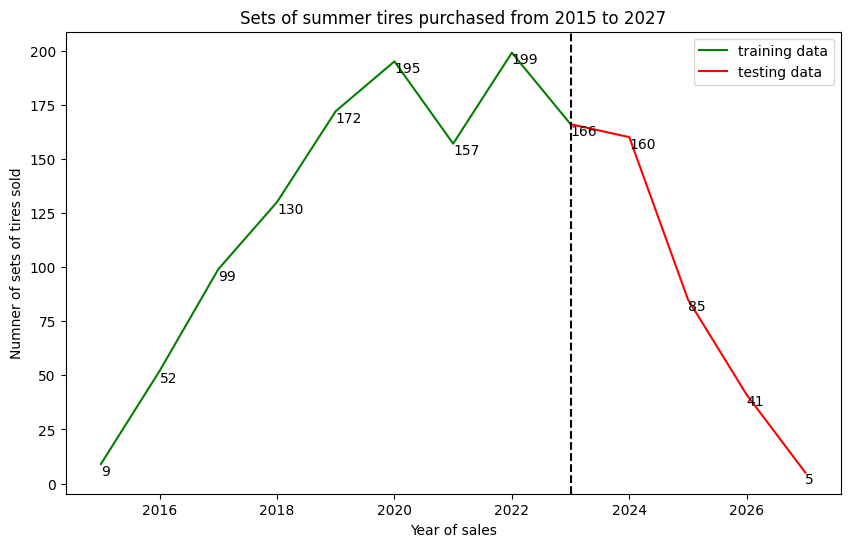

In [ ]:

summer_sales = tires_df[['Last Date of summer purchase','Summer Tires  Sales']]
summer_sales['Year of sales'] = summer_sales['Last Date of summer purchase'].dt.year
summer_sales = summer_sales.groupby('Year of sales')['Summer Tires  Sales'].sum().reset_index()
test = summer_sales.loc[summer_sales['Year of sales']>2022, : ]
train = summer_sales.loc[(summer_sales['Year of sales']>2014) & (summer_sales['Year of sales']<2024),:]
train.index = train['Year of sales']
test.index = test['Year of sales']
train = train.drop('Year of sales' , axis =1)
test = test.drop('Year of sales', axis =1)

fig,ax = plt.subplots(figsize = (10,6))
train.plot(ax = ax, label = 'training set', color = 'g')
test.plot(ax = ax, label = 'testing set', color = 'r')
ax.legend(['training data' , 'testing data'])
for d,s in  zip(list(train.index), train.values.flatten().tolist()[:-1]):
    plt.annotate(round(s,2) , xy = (d,s ), verticalalignment='top',
            fontsize=10)

for d,s in  zip(list(test.index), test.values.flatten().tolist()):
    plt.annotate(round(s,2) , xy = (d,s ),verticalalignment='top',
            fontsize=10)

ax.axvline(2023, color = 'black', ls = '--')
ax.set_title('Sets of summer tires purchased from 2015 to 2027')
plt.ylabel('Numner of sets of tires sold')
plt.show()

## Check for stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller


def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(train)

ADF Statistic: -2.836674
p-value: 0.053223
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Non-stationary


## ACF and PACF plots

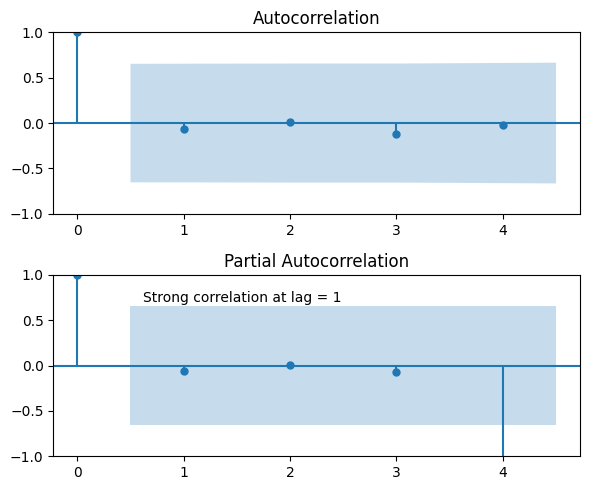

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

lag_acf = 4
lag_pacf = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))
plot_acf(train,lags=lag_acf, ax=ax[0])
plot_pacf(train,lags=lag_pacf, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.85), textcoords='axes fraction')

plt.tight_layout()
plt.show()

## Running ARIMA Model

                             AutoReg Model Results                             
Dep. Variable:     Summer Tires  Sales   No. Observations:                    9
Model:                      AutoReg(3)   Log Likelihood                 -25.612
Method:                Conditional MLE   S.D. of innovations             17.282
Date:                 Sun, 31 Mar 2024   AIC                             61.223
Time:                         05:43:36   BIC                             60.182
Sample:                              3   HQIC                            57.055
                                     9                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    139.7420     45.684      3.059      0.002      50.204     229.280
Summer Tires  Sales.L1    -0.1770      0.374     -0.473      0.636      -0.911       0.

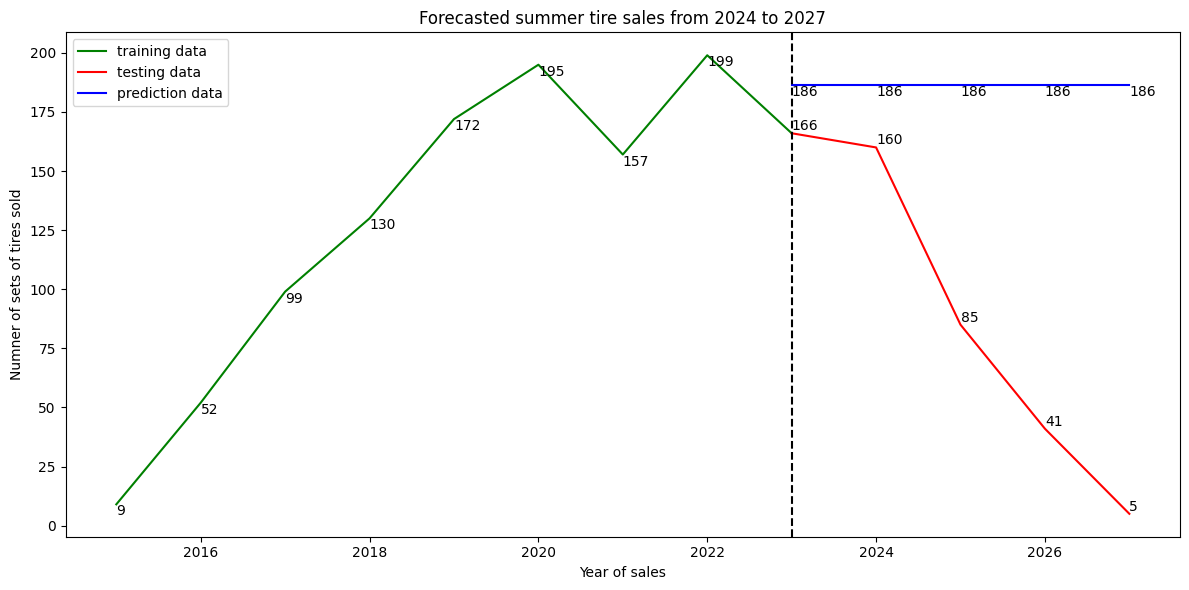

In [ ]:
import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

# Fix seed for reproducible results
SEED = 42
np.random.seed(SEED)


ar_model = AutoReg(train, lags=3).fit()

print(ar_model.summary())
pred = ar_model.predict(start=test.index[0], end=test.index[-1], dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
train.plot(ax = ax, label = 'training set', color = 'g')

test.plot(ax = ax, label = 'testing set', color = 'r')

pred.plot(ax = ax, label = 'prediction set', color = 'b')

ax.set_title('Forecasted summer tire sales from 2024 to 2027')
ax.legend(['training data' , 'testing data', 'prediction data'])
ax.axvline(2023, color = 'black', ls = '--')


for d,s in  zip(list(train.index), train.values.flatten().tolist()[:-1]):
    plt.annotate(round(s,2) , xy = (d,s ),verticalalignment='top',
            fontsize=10)

for d,s in  zip(list(test.index), test.values.flatten().tolist()):
    plt.annotate(round(s,2) , xy = (d,s ), verticalalignment='bottom',
            fontsize=10)
for d,s in  zip(list(pred.index), pred.values.flatten().tolist()):
    plt.annotate(int(s) , xy = (d,s ), verticalalignment='top',
            fontsize=10)
plt.ylabel('Numner of sets of tires sold')
plt.tight_layout()
plt.show()